<a href="https://colab.research.google.com/github/yastiaisyah/DataSynthesis/blob/main/Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset gambar wajah nyata dan palsu
real_dir = r'/content/drive/MyDrive/dataset/real_and_fake_face/training_real/'
real_path = os.listdir(real_dir)

fake_dir = r'/content/drive/MyDrive/dataset/real_and_fake_face/training_fake/'
fake_path = os.listdir(fake_dir)

In [ ]:
def load_img(path):
    '''Loading images from directory
    and changing color space from cv2 standard BGR to RGB
    for better visualization'''
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

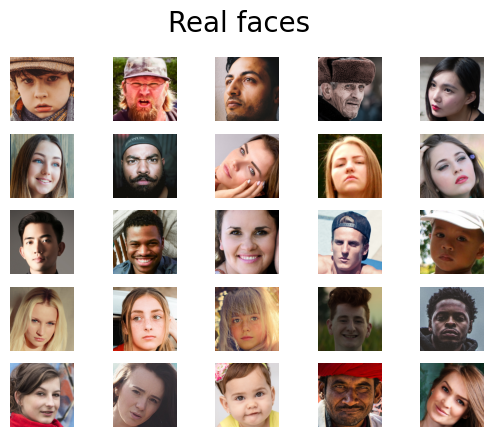

In [ ]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(load_img(real_dir + real_path[i]))
    plt.suptitle("Real faces", fontsize=20)
    plt.axis('off')

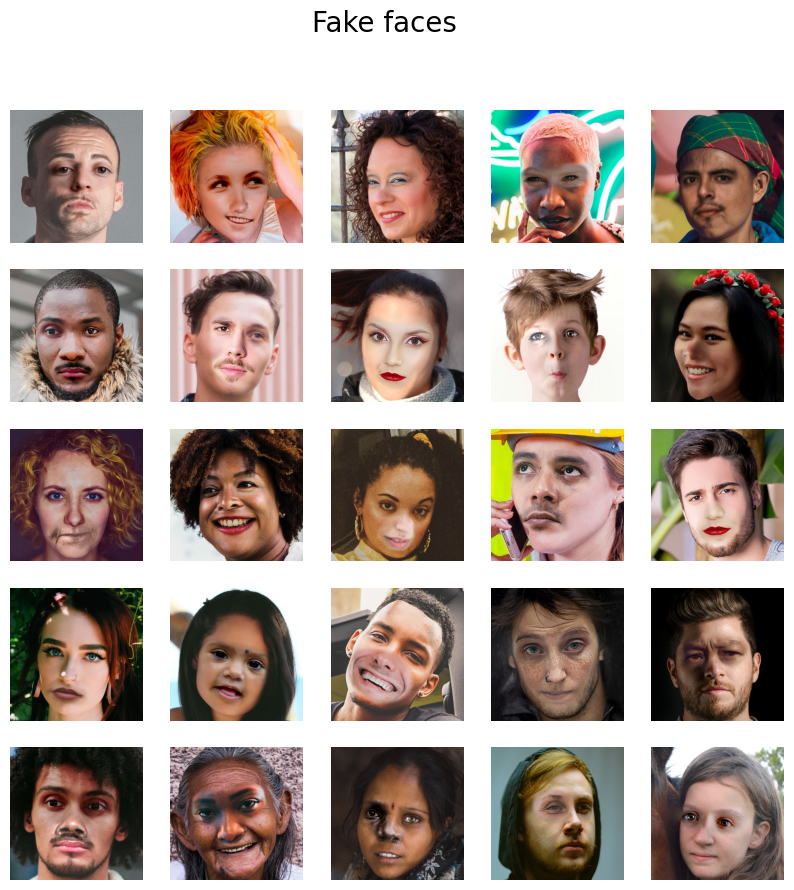

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(load_img(fake_dir + fake_path[i]))
    plt.suptitle("Fake faces", fontsize=20)
    plt.axis('off')

In [ ]:
real_df = pd.DataFrame({'image_path': real_dir + real_path[i], 'label': 1} for i in range(0, 1081))
fake_df = pd.DataFrame({'image_path': fake_dir + fake_path[i], 'label': 0} for i in range(0, 960))

In [ ]:
df = pd.concat([real_df, fake_df], ignore_index=True)
df.tail(10)

image_path  label
2031  /content/drive/MyDrive/dataset/real_and_fake_f...      0
2032  /content/drive/MyDrive/dataset/real_and_fake_f...      0
2033  /content/drive/MyDrive/dataset/real_and_fake_f...      0
2034  /content/drive/MyDrive/dataset/real_and_fake_f...      0
2035  /content/drive/MyDrive/dataset/real_and_fake_f...      0
2036  /content/drive/MyDrive/dataset/real_and_fake_f...      0
2037  /content/drive/MyDrive/dataset/real_and_fake_f...      0
2038  /content/drive/MyDrive/dataset/real_and_fake_f...      0
2039  /content/drive/MyDrive/dataset/real_and_fake_f...      0
2040  /content/drive/MyDrive/dataset/real_and_fake_f...      0

In [ ]:
df = shuffle(df)
df = df.reset_index(drop=True)
df.head(10)

image_path  label
0  /content/drive/MyDrive/dataset/real_and_fake_f...      1
1  /content/drive/MyDrive/dataset/real_and_fake_f...      0
2  /content/drive/MyDrive/dataset/real_and_fake_f...      0
3  /content/drive/MyDrive/dataset/real_and_fake_f...      1
4  /content/drive/MyDrive/dataset/real_and_fake_f...      1
5  /content/drive/MyDrive/dataset/real_and_fake_f...      1
6  /content/drive/MyDrive/dataset/real_and_fake_f...      1
7  /content/drive/MyDrive/dataset/real_and_fake_f...      1
8  /content/drive/MyDrive/dataset/real_and_fake_f...      0
9  /content/drive/MyDrive/dataset/real_and_fake_f...      1

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
image_size = 224
batch_size = 64
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
image_transforms = {'train_transform': A.Compose([A.Resize(image_size, image_size),
                                                  A.HorizontalFlip(p=0.5),
                                                  A.RandomBrightnessContrast(always_apply=False,
                                                                             p=0.4),
                                                  A.Solarize(always_apply=False,
                                                             p=0.4,
                                                             threshold=(42, 42)),
                                                  A.MultiplicativeNoise(always_apply=False,
                                                                        p=0.8,
                                                                        multiplier=(0.6800000071525574, 1.409999966621399),
                                                                        per_channel=True,
                                                                        elementwise=True),
                                                  A.Normalize(mean=(0.485, 0.456, 0.406),
                                                              std=(0.229, 0.224, 0.225),
                                                              max_pixel_value=255.0,
                                                              p=1.0),
                                                  ToTensorV2()]),

                   'validation_transform': A.Compose([A.Resize(image_size, image_size),
                                                      A.Normalize(mean=(0.485, 0.456, 0.406),
                                                                  std=(0.229, 0.224, 0.225),
                                                                  max_pixel_value=255.0,
                                                                  p=1.0),
                                                      ToTensorV2()]),
                   'visualization_transform': A.Compose([A.Resize(image_size, image_size),
                                                         A.HorizontalFlip(p=0.5),
                                                         A.RandomBrightnessContrast(always_apply=False,
                                                                                    p=0.4),
                                                  A.Solarize(always_apply=False,
                                                             p=0.4,
                                                             threshold=(42, 42)),
                                                  A.MultiplicativeNoise(always_apply=False,
                                                                        p=0.8,
                                                                        multiplier=(0.6800000071525574, 1.409999966621399),
                                                                        per_channel=True,
                                                                        elementwise=True)])}

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_labels, image_dir, transform=None, target_transform=None):
        self.image_labels = image_labels
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.image_labels)


    def __getitem__(self, index):
        image_path = self.image_dir.iloc[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.image_labels.iloc[index]
        if self.transform:
            image = self.transform(image=image)['image']
        if self.target_transform:
            label = self.target_transform(label=label)
        return image, label

In [ ]:
train_label = train_df['label']
train_features = train_df['image_path']

val_label = val_df['label']
val_features = val_df['image_path']

train_dataset = ImageDataset(train_label,
                             train_features,
                             transform=image_transforms['train_transform'])
val_dataset = ImageDataset(val_label,
                           val_features,
                           transform=image_transforms['validation_transform'])
visual_train_dataset =  ImageDataset(train_label,
                                     train_features,
                                     transform=image_transforms['visualization_transform'])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
visual_loader = DataLoader(visual_train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
val_loader

In [ ]:
visual_train_f, visual_train_t = next(iter(visual_loader))
print(f'Feature batch shape: {visual_train_f.size()}')
print(f'Target batch shape: {visual_train_t.size()}')

Feature batch shape: torch.Size([64, 224, 224, 3])
Target batch shape: torch.Size([64])


In [ ]:
for item in visual_loader:
    img, label = item[0], item[1]
    print(img, label)

Streaming output truncated to the last 5000 lines.
          ...,
          [155, 197, 214],
          [185, 210, 221],
          [188, 203, 143]]],


        [[[255, 224, 169],
          [255, 223, 173],
          [255, 232, 184],
          ...,
          [199, 146, 104],
          [206, 153, 108],
          [211, 155, 114]],

         [[255, 226, 174],
          [255, 233, 184],
          [255, 236, 187],
          ...,
          [204, 151, 114],
          [209, 156, 114],
          [213, 158, 116]],

         [[255, 232, 178],
          [255, 234, 185],
          [255, 243, 196],
          ...,
          [204, 153, 117],
          [211, 158, 117],
          [215, 162, 119]],

         ...,

         [[121, 111,  69],
          [194, 154, 110],
          [153, 119,  78],
          ...,
          [204, 145, 100],
          [204, 146, 101],
          [202, 147, 106]],

         [[ 82,  91,  59],
          [184, 153, 106],
          [166, 129,  93],
          ...,
          [209, 149, 1

In [ ]:
def plot_batch(features, target, batch_size=batch_size):
    '''Shows one batch of augmented images'''
    plt.figure(figsize=(10, 40))
    for i in range(batch_size):
        img = features[i]
        label = target[i]

        plt.subplot(16, 4, i+1)
        plt.title(f'Class: {label}')
        plt.imshow(img)
    plt.show()

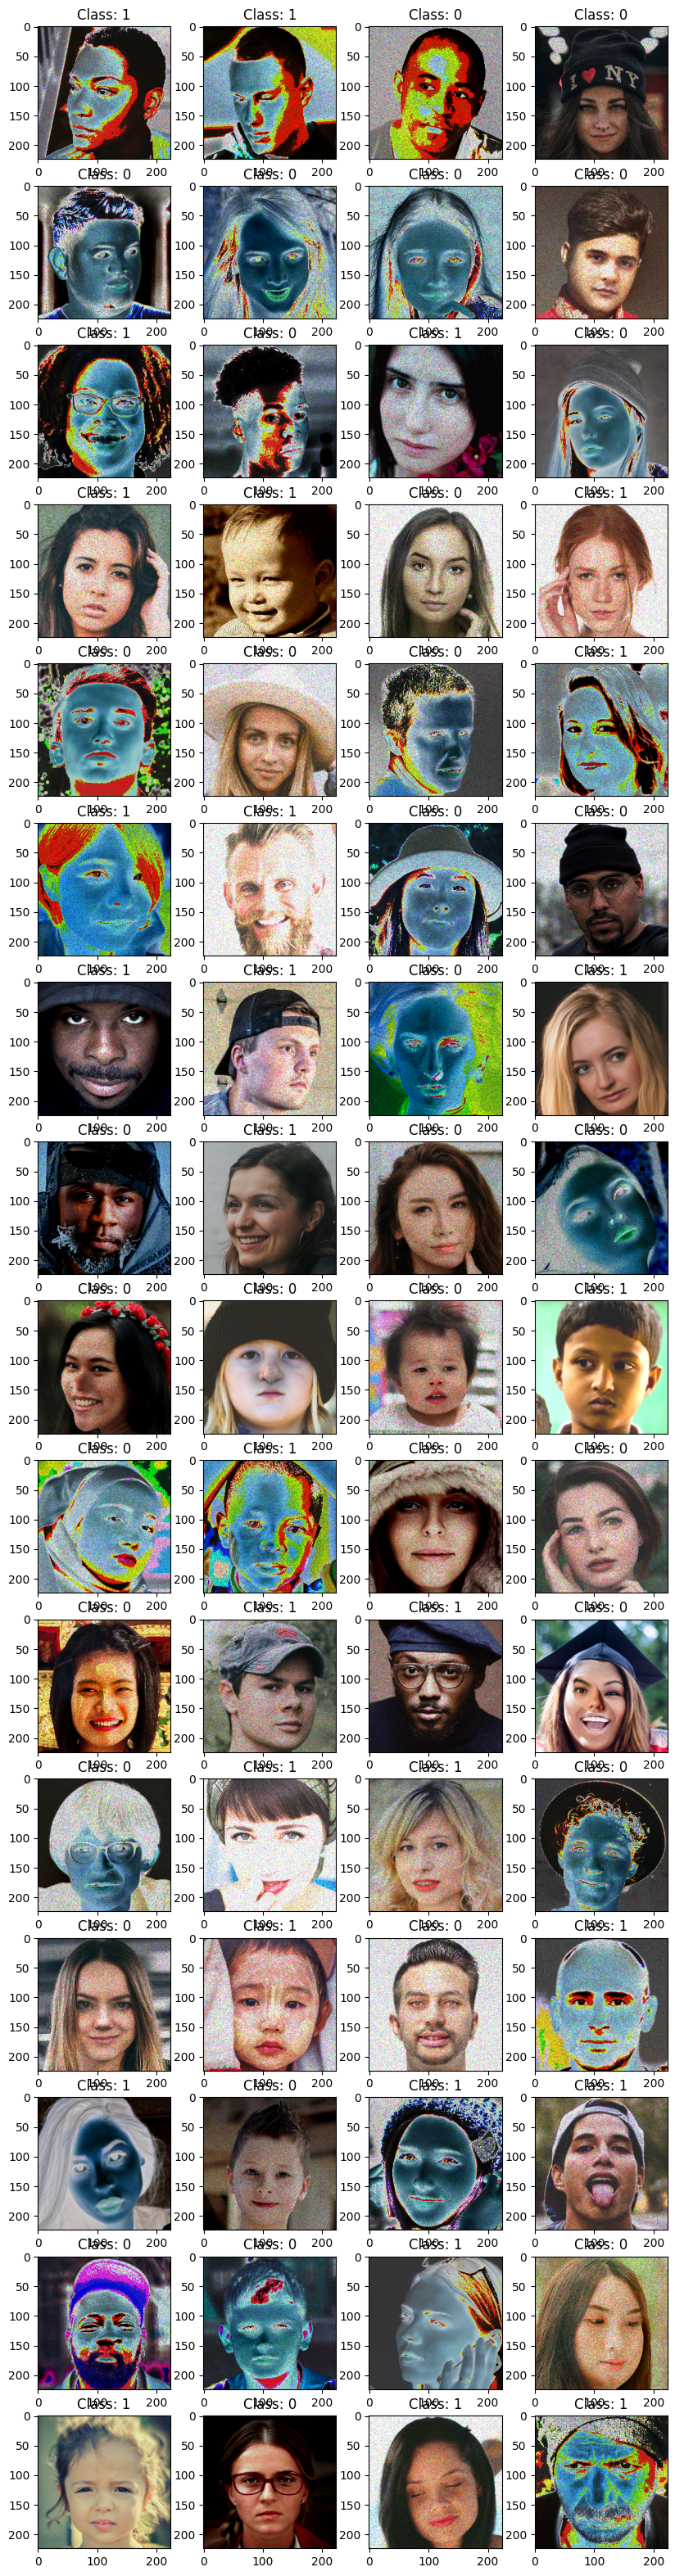

In [ ]:
plot_batch(visual_train_f, visual_train_t)